In [4]:
%reload_ext autoreload
%autoreload 2

In [69]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import glob
import xesmf as xe
import numpy as np
from tqdm import tqdm
from scipy.spatial import KDTree
import cartopy.crs as ccrs

from nzdownscale.downscaler.validate_ERA import ValidateERA
from nzdownscale.dataprocess import era5, stations
from nzdownscale.dataprocess.config import VAR_ERA5, VAR_STATIONS, STATION_LATLON

# Load DeepSensor outputs
If outputs haven't been saved to a file yet, run infer.py

In [6]:
model_name = 'hourly_1e-5_v2'
var = 'temperature'
top_dir = '/mnt/temp/projects/DeepWeather/data_delete/DeepSensor/models'

model_dir = f'{top_dir}/{var}/{model_name}'
model_path = f'{model_dir}/{model_name}.pt'
train_metadata_path = f'{model_dir}/metadata_{model_name}.pkl'

data_processor_path = f'{model_dir}/data_processor.pkl'
task_loader_path = f'{model_dir}/task_loader.pkl'

outputs_dir = f'{top_dir}/{var}/{model_name}/outputs/'

remove_stations_list = [
    "TAUPO AERO AWS",
    "CHRISTCHURCH AERO",
    "MT COOK EWS",
    "AUCKLAND AERO",
    "ALEXANDRA AWS",
    "TOLAGA BAY WXT AWS",
    "WELLINGTON AERO",
    "BLENHEIM AERO",
    "DUNEDIN AERO AWS",
]

In [7]:
validate = ValidateERA(model_path, 
                       data_processor_path, 
                       task_loader_path, 
                       train_metadata_path)

Unpickling data_processor


Unpickling task_loader
Unpickling train_metadata
Loading elevation data
Producing predictions at resolution: 0.01


In [10]:
lowres_topo = validate.data_processor_dict['aux_ds']['elevation']
lowres_topo = validate.data_processor.unnormalise(lowres_topo)

# Load predictions

In [11]:
year = 2016
month = 1
# fpaths = glob.glob(f'{outputs_dir}predictions_{year}.nc')
fpaths = f'{outputs_dir}predictions_{year}{str(month).zfill(2)}.nc'
ds = xr.open_mfdataset(fpaths, combine='by_coords')

In [12]:
time = ds.time.values

# Load ERA5 

In [13]:
process_era5 = era5.ProcessERA5()
era5_ds = process_era5.load_ds(var, year)

In [14]:
era5_ds = era5_ds.sel(time=time)

In [15]:
# era5_interp = era5.interpolate_era5(era5_ds, ds, var)

# Load Stations

In [16]:
process_stations = stations.ProcessStations()
stations_to_validate = process_stations.load_stations_time(var, time, keep_stations=remove_stations_list)

Loading stations:  22%|██▏       | 103/468 [00:22<01:18,  4.62it/s]

MT COOK EWS


Loading stations: 100%|██████████| 468/468 [01:57<00:00,  3.99it/s]


200 stations with data at prediction time(s)
Keeping TAUPO AERO AWS
Keeping CHRISTCHURCH AERO
Keeping MT COOK EWS
Keeping AUCKLAND AERO
Keeping ALEXANDRA AWS
Keeping TOLAGA BAY WXT AWS
Keeping WELLINGTON AERO
Keeping BLENHEIM AERO
Keeping DUNEDIN AERO AWS
Kept 9 stations


In [22]:
stations_to_validate = stations_to_validate.reset_index().set_index('station_name')

station_dict = {}
for station in remove_stations_list:
    station_dict[station] = {**STATION_LATLON[station]}
    station_lat = station_dict[station]['latitude']
    station_lon = station_dict[station]['longitude']

    if station in stations_to_validate.index.get_level_values('station_name'):
        station_values = stations_to_validate.loc[station]
        station_dict[station]['values'] = station_values
        print(station)
        # print(station_values)
    else:
        print(f'{station} not in stations_to_validate')
        del station_dict[station]

TAUPO AERO AWS
CHRISTCHURCH AERO
MT COOK EWS
AUCKLAND AERO
ALEXANDRA AWS
TOLAGA BAY WXT AWS
WELLINGTON AERO
BLENHEIM AERO
DUNEDIN AERO AWS


In [23]:
def create_station_df(station_dict, time_slice, var):
    
    station_df = pd.DataFrame(index=time_slice)
    
    station_dict_values = station_dict[station]['values'].reset_index().set_index('time')
    
    values = []
    for time in time_slice:
        if time in station_dict_values.index:
            values.append(station_dict_values.loc[time][f'{var}_station'])
        else:
            values.append(None)

    station_df[f'{var}_station'] = values
    return station_df

# Plot timeseries

In [24]:
time_slice = pd.date_range(f'{year}-{str(month).zfill(2)}-01', f'{year}-{str(month).zfill(2)}-31T23:00:00', freq='H')

In [27]:
era5_var = VAR_ERA5[var]['var_name']
era5_ds_compute = era5_ds[era5_var].sel(time=time_slice).compute()
pred_ds_compute = ds.sel(time=time_slice).compute()

In [70]:
# for ERA5: make adjustments so it doesnt return nans

# station = 'AUCKLAND AERO'
# print(f'latitude: {station_dict[station]['latitude']}, longitude: {station_dict[station]['longitude']}')
# era5_ds_compute.isel(time=0).sel(latitude=station_dict[station]['latitude']-0.1,
#                                 longitude=station_dict[station]['longitude'] - 0.1,
#                                 method='nearest')

In [71]:
# fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# era5_ds_compute.isel(time=0).plot(ax = ax)
# ax.plot(station_dict[station]['longitude']-0.1, station_dict[station]['latitude']-0.1 , 'ro', alpha=0.5)
# ax.set_extent([172, 175, -35, -40])

In [60]:
adj_lon = {st: 0 for st in remove_stations_list}
adj_lat = {st: 0 for st in remove_stations_list}

adj_lon['WELLINGTON AERO'] = -0.1
adj_lon['AUCKLAND AERO'] = -0.1
adj_lat['AUCKLAND AERO'] = -0.1

In [68]:
station_time = {}

for station in tqdm(remove_stations_list):
    # print(station)
    
    pred = pred_ds_compute.sel(latitude=station_dict[station]['latitude'] ,
                                 longitude=station_dict[station]['longitude'] ,
                                 method='nearest')
    pred_values = pred[var].values
    std_values = pred['std'].values                
    # print('computed pred')
    
    era5_values = era5_ds_compute.sel(latitude=station_dict[station]['latitude']+ adj_lat[station],
                    longitude=station_dict[station]['longitude'] + adj_lon[station],
                    method='nearest').values
    # print('computed era5')
    
    if var == 'temperature':
        era5_values = era5_values - 273.15
        low_res_topo_at_location = float(lowres_topo.sel({'latitude': station_dict[station]['latitude'],
                                                    'longitude': station_dict[station]['longitude']},
                                                    method='nearest').values)
        elevation = station_dict[station]['elevation']
        lapse_rate = 0.0065 * (elevation - low_res_topo_at_location)
        lapse_era5_values = era5_values - lapse_rate

    station_df = create_station_df(station_dict, time_slice, var)
    station_df['pred'] = pred_values
    station_df['std'] = std_values
    station_df['era5'] = era5_values
    if var == 'temperature':
        station_df['era5_lapse'] = lapse_era5_values
    
    station_time[station] = station_df

100%|██████████| 9/9 [00:00<00:00, 31.65it/s]


In [29]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [30]:
units = {'temperature': '°C', 
        'precipitation': 'mm/hr'}

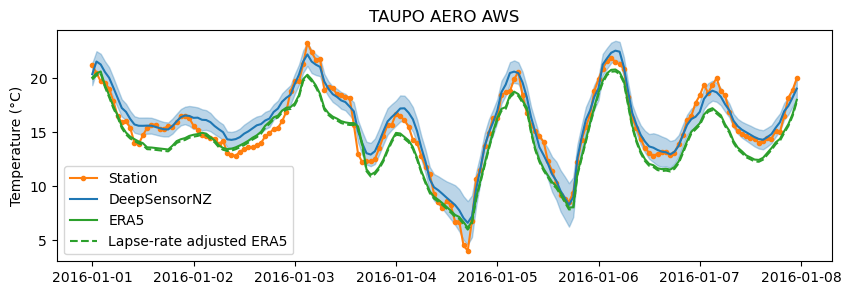

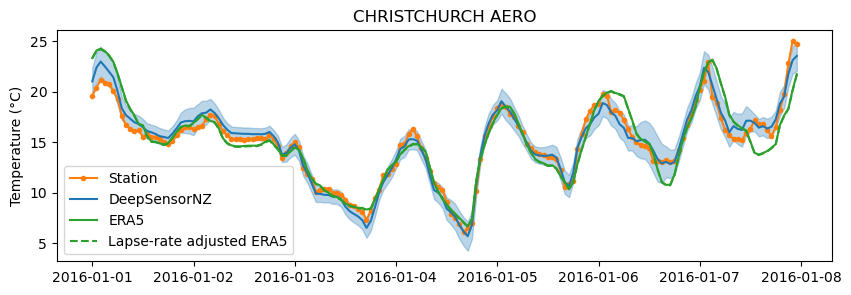

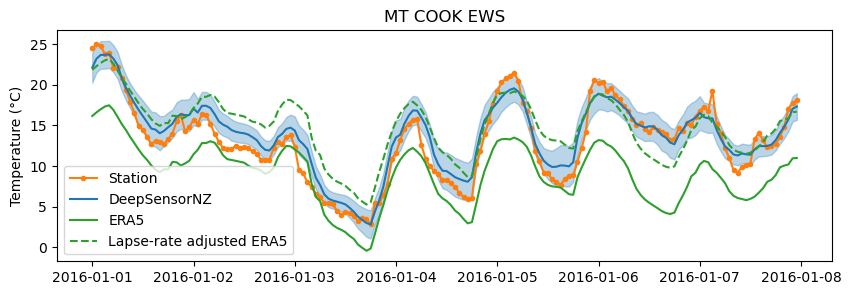

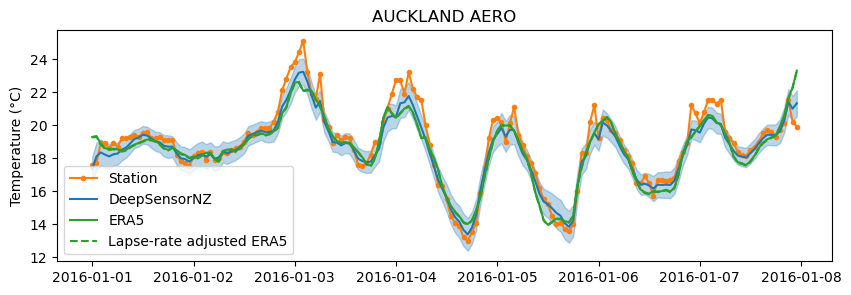

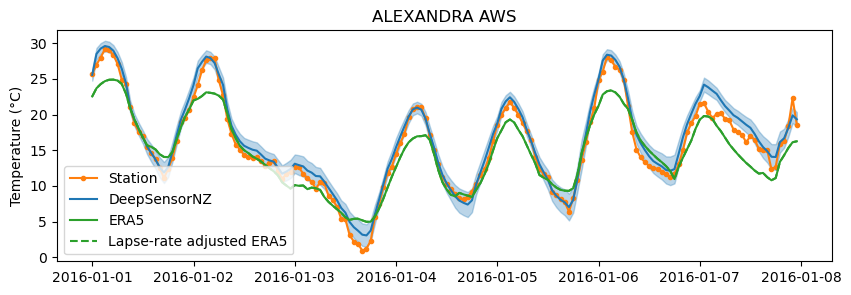

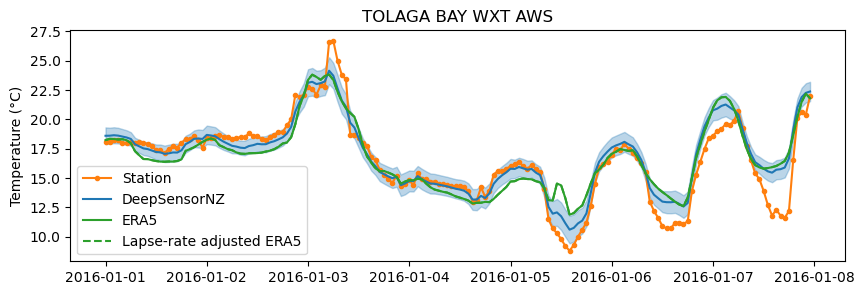

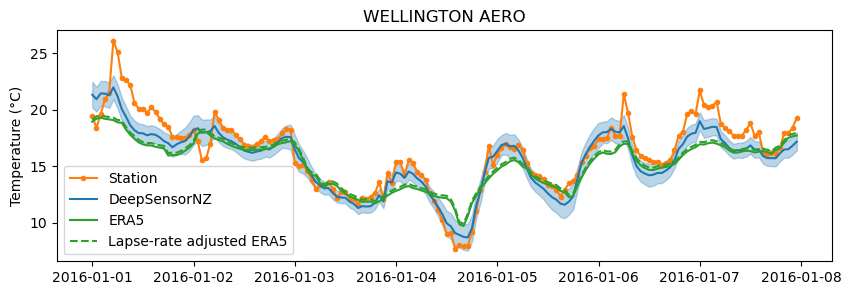

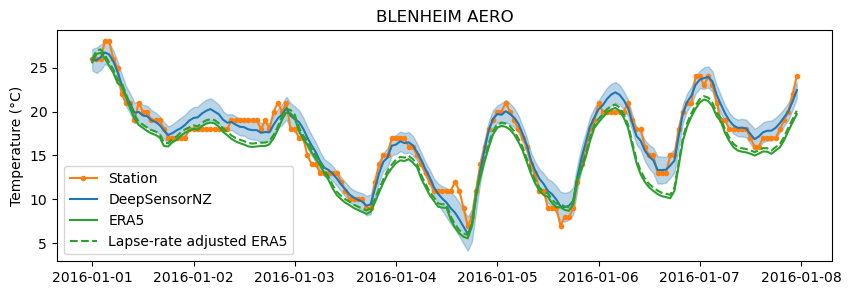

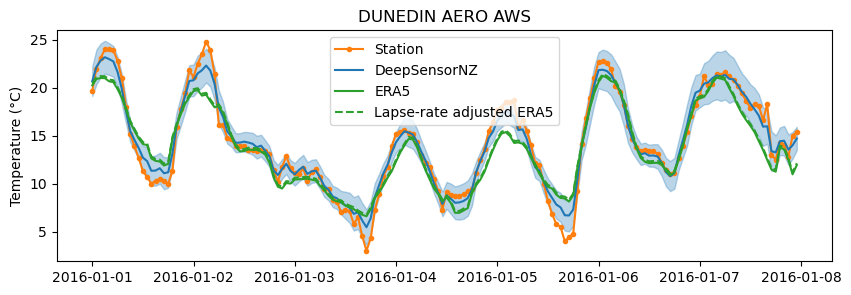

In [64]:
start = 0
end = 24 * 7
for station in remove_stations_list:

    times_to_plot = time_slice[start:end]
    station_df = station_time[station]

    pred_at_times = station_df['pred'][start:end]
    std_at_times = station_df['std'][start:end]
    station_at_times = station_time[station][f'{var}_station'].values[start:end]
    era5_at_times = station_df['era5'][start:end]
    if var == 'temperature':
        era5_lapse_at_times = station_df['era5_lapse'][start:end]

    fig, ax = plt.subplots(figsize=(10, 3)) 
    ax.plot(times_to_plot, station_at_times, label='Station', marker='o', markersize=3, color=colors[1])
    ax.plot(times_to_plot, pred_at_times, label='DeepSensorNZ', color=colors[0])
    ax.fill_between(times_to_plot, (pred_at_times - std_at_times).loc[times_to_plot], 
            (pred_at_times + std_at_times).loc[times_to_plot], 
            color=colors[0], alpha=0.3)
    ax.plot(times_to_plot, era5_at_times, label='ERA5', color=colors[2])
    if var == 'temperature':
        ax.plot(times_to_plot, era5_lapse_at_times, label='Lapse-rate adjusted ERA5', color=colors[2], linestyle='--')

    ax.set_ylabel(f'{var.capitalize()} ({units[var]})')
    ax.legend()
    ax.set_title(station);